<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [15]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import spacy
from spacy.tokenizer import Tokenizer
from collections import Counter
import squarify
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read thru the documentation to accomplish this task. 

`Tip:` You will need to install the `bs4` library inside your conda environment. 

In [2]:
job_listings = pd.read_csv("data/job_listings.csv")

nlp = spacy.load("en_core_web_lg")

In [3]:
def clean_soup(df_column, spec_chars_remove):
    
    """
    Input: dataframe column and list of specific characters to remove, 
    
    Output: List of cleaned observations
    """
    
    soupy = [BeautifulSoup(df_column[ii], 'lxml').get_text() 
             for ii in range(df_column.shape[0])]
    
    for char in spec_chars_remove:
        soupy = [soupy[ii].replace(char, ' ') for ii in range(len(soupy))]
        
    to_clean = ['[^A-Za-z0-9 ]+', '   ', '  ']
    
    for char in to_clean:
        soupy = [re.sub(char, ' ', soupy[ii]) for ii in range(len(soupy))]
        
    df_feature = pd.Series([nlp(soupy[ii].lower().strip()) for ii in range(len(soupy))])
        
    for row in range(df_feature.shape[0]):
        df_feature[row] = " ".join([token.lemma_ for token in df_feature[row]])
         
    return df_feature

In [4]:
job_listings['description_redo'] = clean_soup(job_listings['description'],
                                              ['b"',"b'",'b/',"\\n"])
job_listings['description_redo'].head()

0    job requirement conceptual understanding in ma...
1    job description as a data scientist 1 -PRON- w...
2    as a data scientist -PRON- will be work on con...
3    4 969 6 756 a monthcontractunder the general s...
4    location usa xe2 x80 x93 multiple location 2 y...
Name: description_redo, dtype: object

In [5]:
def make_tokens(df_feature, addl_stop_words = []):
    
    """
    Input: Column of a dataframe/ Pandas Series, 
    stop words you'd like to add to nlp's defaults
    
    Output: List consisting of tokens for each observation
    
    Assumes: nlp object initialized as nlp
    """
    
    tokens = []
    tokenizer = Tokenizer(nlp.vocab)

    STOP_WORDS = nlp.Defaults.stop_words.union(addl_stop_words)

    for doc in tokenizer.pipe(df_feature, batch_size=500):

        doc_tokens = []

        for token in doc: 
            if token.text not in STOP_WORDS:
                doc_tokens.append(token.text.lower())

        tokens.append(doc_tokens)

    return tokens

In [87]:
addl_stop_words = ['-PRON-','pron', 'data', 'scientist', 'job', 
                   'requirements', 'requirement', 'require',
                   'work', 'location', 'understanding',
                   'description', 'learning', 'science',
                  'model', 'like', 'machine','year', 's',
                  'apply', 'large', 'use', 'skill','skills',
                  'include', 'need', 'help', 'overview']

job_listings['tokens'] = make_tokens(job_listings['description_redo'], addl_stop_words)
job_listings['tokens'].head()

0    [conceptual, nai, xc2, xa8ve, bayes, k, mean, ...
1    [1, build, datum, pipeline, micro, service, cl...
2    [consult, business, responsible, analyze, comp...
3    [4, 969, 6, 756, monthcontractunder, general, ...
4    [usa, xe2, x80, x93, multiple, 2, analytic, ex...
Name: tokens, dtype: object

In [75]:
def count(docs):
    """
    Input: Series of spacy docs objects / dataframe column
    
    Output: Pandas dataframe consisting of words and their 
    stats based on how many times they appear in the series
    """
    word_counts = Counter()
    appears_in = Counter()
       
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())
        
    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
    return wc.sort_values(by='rank')

In [88]:
wc = count(job_listings['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
50,datum,421,3614,1.0,0.028525,0.028525,0.988263
10,experience,409,1958,2.0,0.015455,0.043980,0.960094
231,xe2,315,1417,3.0,0.011184,0.055164,0.739437
279,x80,314,1404,4.0,0.011082,0.066246,0.737089
94,team,370,1373,5.0,0.010837,0.077083,0.868545


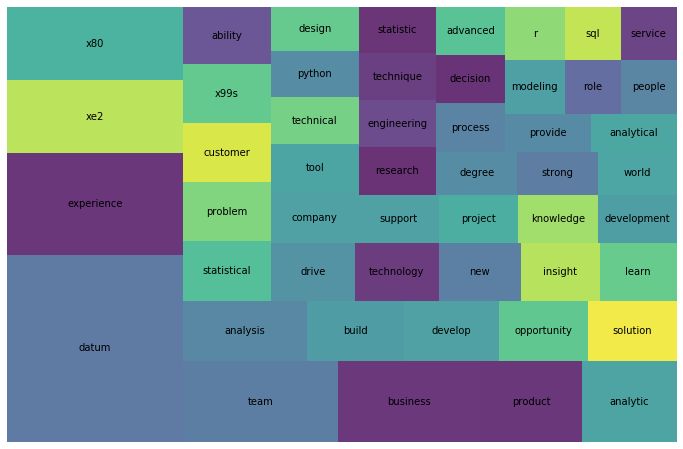

In [89]:
wc_top50 = wc[wc['rank'] <= 50] #explore what the top words are and help find additional stop_words

plt.rcParams['figure.figsize'] = (12,8)
squarify.plot(sizes=wc_top50['pct_total'], label=wc_top50['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [90]:
from sklearn.feature_extraction import text 

stop_words = text.ENGLISH_STOP_WORDS.union(addl_stop_words)


vect = CountVectorizer(stop_words= stop_words) #can use union on stop_words to add stop words

#Learn our Vocab
dtm = vect.fit_transform(job_listings['description_redo'])

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm

,00,000,02115,03,0305,0356,04,062,06366,08,...,zero,zeus,zf,zheng,zillow,zogsport,zone,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
423,0,2,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

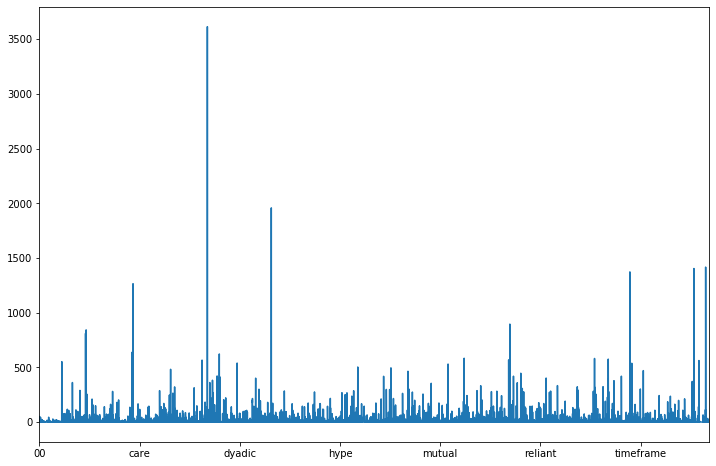

In [91]:
dtm.sum().plot()

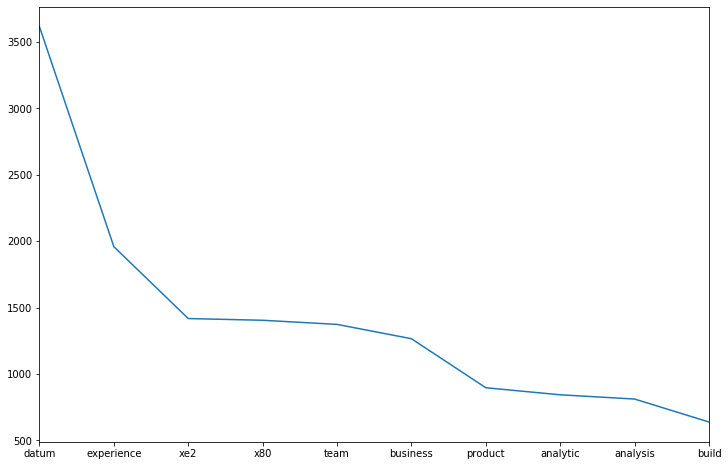

In [92]:
dtm.sum().sort_values(ascending = False)[:10].plot()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words= stop_words, max_features=8000)

dtm = tfidf.fit_transform(job_listings['description_redo'])

dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

dtm.head()

,00,000,02115,03,0305,0356,04,062,06366,08,...,zero,zeus,zf,zheng,zillow,zogsport,zone,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.111285,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


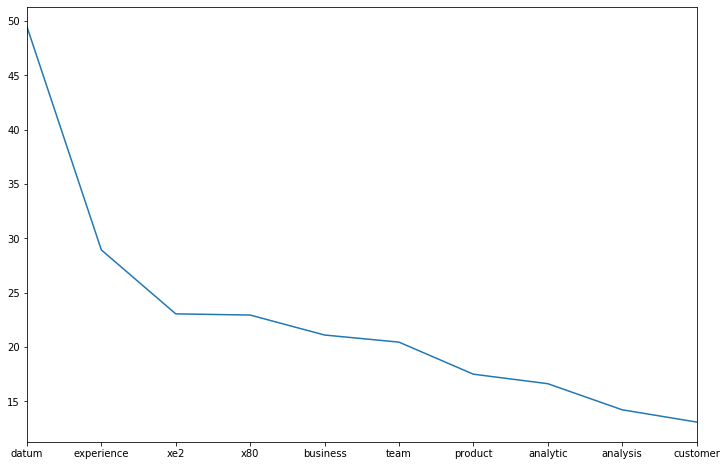

In [94]:
dtm.sum().sort_values(ascending = False)[:10].plot()

## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [95]:
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [108]:
nearest_vectors, nearest_loc = nn.kneighbors([dtm.iloc[356]])

nearest_loc

array([[356, 201, 276, 392, 301]])

In [122]:
for neighbor in list(nearest_loc):
    print(job_listings['title'].iloc[neighbor])
    print(f'{job_listings['description_redo'].iloc[neighbor][100:400]}')

356                                Data Science Intern
201                           Data Science Internships
276                     Data Scientist, Infrastructure
392    Data Scientist, Analytics - Messenger Relevance
301                          Data Scientist, Analytics
Name: title, dtype: object
Series([], Name: description_redo, dtype: object)



## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 